## Word Recognition

In [44]:
# Select one model from ResNet18, ResNet34, ResNet152, InceptionV3, AlexNet
model_choice = "ResNet152"

In [8]:
import os

# Get the working directory where the dataset is located
woking_dir = '../'

# Check the working directory
# You should see the datasets
os.listdir(woking_dir)

['.ipynb_checkpoints',
 'AlexNet',
 'asl-alphabet-test',
 'asl_alphabet',
 'InceptionV3',
 'ResNet',
 'word']

In [1]:
#!pip install wordfreq

In [3]:
from wordfreq import top_n_list

In [4]:
# Population
word_list = top_n_list('en', 1000)
# Test words
words = top_n_list('en', 100)

### 2.1 Test images generation

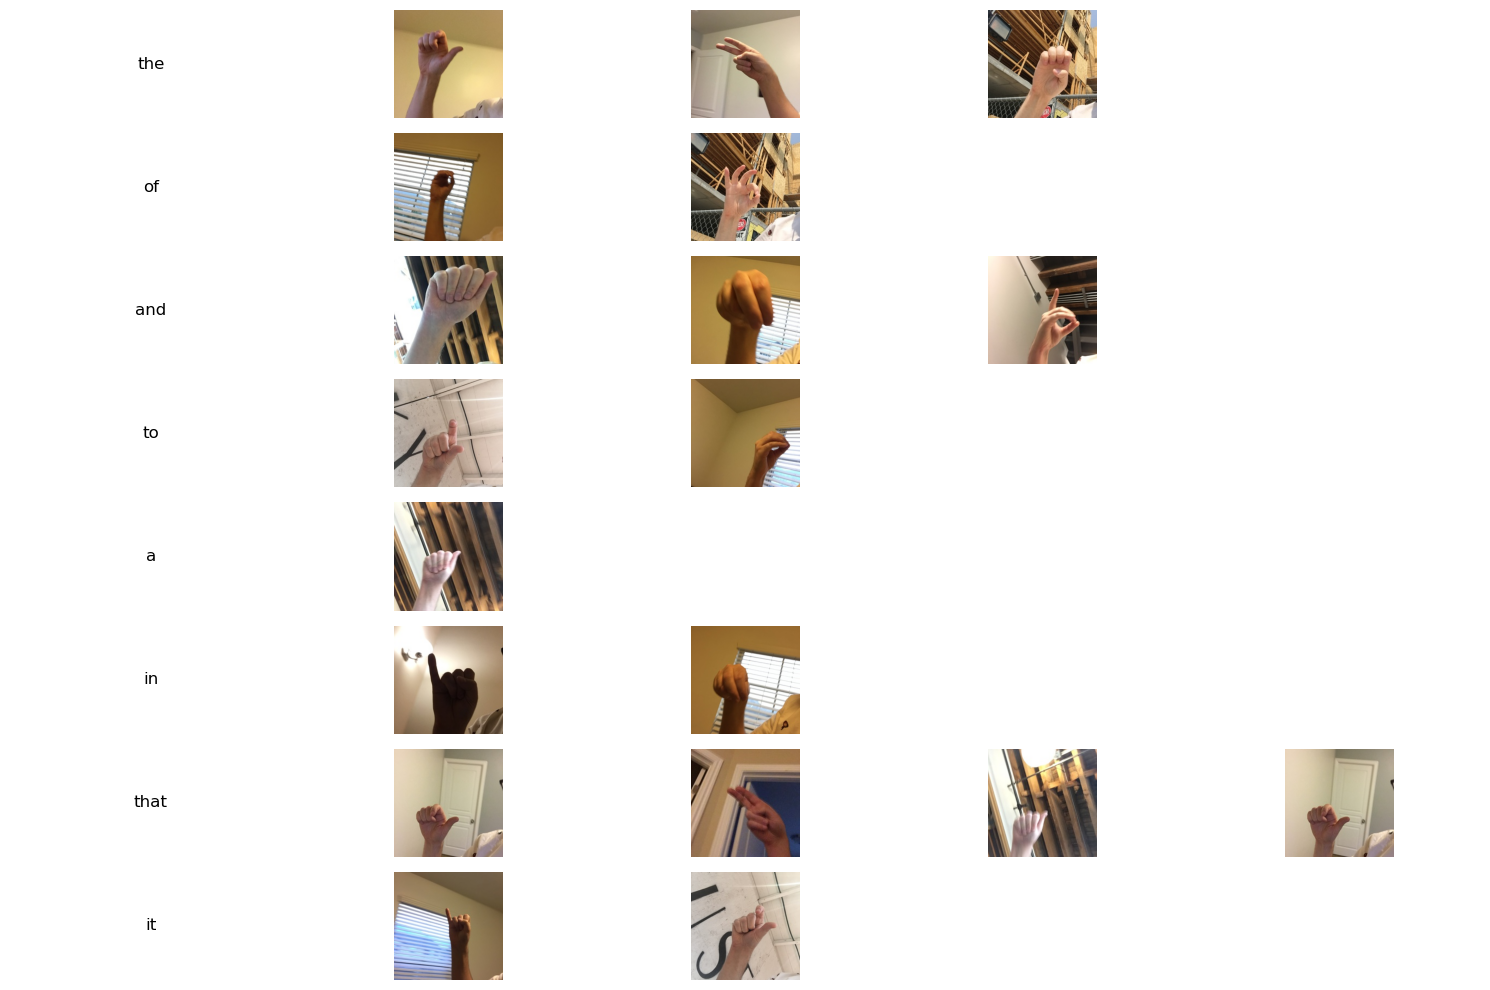

In [14]:
import random
import matplotlib.pyplot as plt
from IPython.display import display, Image

# Set base paths and common words
path_to_test = os.path.join(woking_dir, 'asl-alphabet-test', 'asl-alphabet-test')
words_demo = ["the", "of", "and", "to", "a", "in", "that", "it"]

# Function: Randomly select a picture from the folder with the specified letter
def random_image(letter):
    letter_path = os.path.join(path_to_test, letter)
    images = os.listdir(letter_path)
    random_image_filename = random.choice(images)
    return os.path.join(letter_path, random_image_filename)

# Generate a list of image paths for common words
selected_images = []
for word in words_demo:
    word_images = []
    for letter in word.upper():
        if letter.isalpha():  
            img_path = random_image(letter)
            word_images.append(img_path)
    selected_images.append(word_images)

# Calculate max number of columns
max_cols = max(map(len, selected_images))

# Assuming 'words_demo' contains your labels and 'selected_images' contains lists of image paths
max_cols = max(len(images) for images in selected_images) + 1  # Add one for the label column
fig, axes = plt.subplots(len(words_demo), max_cols, figsize=(15, 10), squeeze=False)

for row, word_images in enumerate(selected_images):
    # Set the label in the first column
    axes[row, 0].text(0.5, 0.5, words_demo[row], va='center', ha='center', fontsize=12, transform=axes[row, 0].transAxes)
    axes[row, 0].axis('off')  # Hide the frame and ticks

    # Display images in the subsequent columns
    for col in range(1, max_cols):  # Start from 1 to leave space for the label
        if col-1 < len(word_images):  # Adjust index for images
            img_path = word_images[col-1]  # Adjust index to access image
            img = plt.imread(img_path)
            axes[row, col].imshow(img)
            axes[row, col].axis('off')
        else:
            axes[row, col].axis('off')  # Turn off unused axes

plt.tight_layout()
plt.savefig('test_img_generation.png')
plt.show()




### 2.2 Word recognition without text analysis techniques

In [45]:
# Load the model
import torch
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image


if model_choice == 'ResNet18':
    saved_model = models.resnet18(pretrained=False)
    model_path = '../ResNet/ResNet18/outputs/fine_tuned_resnet.pth'
elif model_choice == 'ResNet34':
    saved_model = models.resnet34(pretrained=False)
    model_path = '../ResNet/ResNet34/outputs/fine_tuned_resnet.pth'
elif model_choice == 'ResNet152':
    saved_model = models.resnet152(pretrained=False)
    model_path = '../ResNet/ResNet152/outputs/fine_tuned_resnet.pth'

# Set the number of categories
num_classes = 29  # Make sure this matches the number of categories used when training

# Adjust the fully connected layer to match the number of categories
num_ftrs = saved_model.fc.in_features
saved_model.fc = torch.nn.Linear(num_ftrs, num_classes)

# Load the status dictionary

model_state_dict = torch.load(model_path)
saved_model.load_state_dict(model_state_dict)  # 确保没有错误发生

# Transfer the model to the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
saved_model = saved_model.to(device)

# Set to evaluation mode
saved_model.eval()



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [46]:
transform=transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Function: Recognize letters in pictures
def recognize_image(image_path):
    image = Image.open(image_path) 
    image = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        outputs = saved_model(image)
        _, predicted = torch.max(outputs, 1)
        return predicted

# The sequence of pictures generated for each word is recognized and compared with the original word
correct_count = 0
total_count = 0
errors = []

for word in words:
    recognized_letters = ''
    for letter in word.upper():
        if letter.isalpha():
            image_path = random_image(letter)
            predicted_letter = recognize_image(image_path)
            recognized_letters += chr(predicted_letter + ord('A'))
    
    if recognized_letters == word.upper():
        correct_count += 1
    else:
        errors.append((word, recognized_letters.lower()))
    
    total_count += 1


accuracy = (correct_count / total_count) * 100
print(f'Accuracy: {accuracy:.2f}%')
print('Errors:', errors)

Accuracy: 18.00%
Errors: [('the', 'lhe'), ('to', 'lo'), ('and', 'amd'), ('of', 'df'), ('in', 'im'), ('is', 'te'), ('for', 'fdd'), ('that', 'lhmt'), ('you', 'yik'), ('it', 'il'), ('on', 'oa'), ('with', 'wixh'), ('this', 'ahie'), ('was', 'wmm'), ('be', 'me'), ('as', 'me'), ('are', 'mkb'), ('have', 'hake'), ('at', 'bx'), ('not', 'bdl'), ('by', 'my'), ('but', 'bbt'), ('from', 'ykom'), ('or', 'dr'), ('an', 'wm'), ('your', 'ydkk'), ('so', 'eo'), ('his', 'hie'), ('they', 'ehey'), ('one', 'ome'), ('can', 'mbm'), ('just', 'jujl'), ('about', 'aboum'), ('out', 'obl'), ('has', 'hym'), ('when', 'whem'), ('more', 'mdke'), ('no', 'mo'), ('were', 'webe'), ('had', 'haz'), ("it's", 'ixe'), ('their', 'eheii'), ('there', 'xheue'), ('her', 'hel'), ('which', 'whimh'), ('time', 'lime'), ('get', 'gem'), ('been', 'beem'), ('would', 'wobld'), ('she', 'bhe'), ('new', 'mew'), ('how', 'hdw'), ("don't", 'ddml'), ('some', 'mome'), ('also', 'aleo'), ('them', 'lhem'), ('now', 'mow'), ('other', 'dthek'), ("i'm", 'im'),

### 2.3 Word recognition with text analysis techniques


In [18]:
def levenshtein_distance(s1, s2):
    if len(s1) < len(s2):
        return levenshtein_distance(s2, s1)

    if len(s2) == 0:
        return len(s1)

    previous_row = range(len(s2) + 1)
    for i, c1 in enumerate(s1):
        current_row = [i + 1]
        for j, c2 in enumerate(s2):
            insertions = previous_row[j + 1] + 1
            deletions = current_row[j] + 1
            substitutions = previous_row[j] + (c1 != c2)
            current_row.append(min(insertions, deletions, substitutions))
        previous_row = current_row

    return previous_row[-1]


In [19]:
def find_closest_word(predicted_word, word_list):
    filtered_words = [word for word in word_list if len(word) == len(predicted_word)]
    closest_word = None
    min_distance = float('inf')
    for word in filtered_words:
        distance = levenshtein_distance(predicted_word, word)
        if distance < min_distance:
            min_distance = distance
            closest_word = word
    return closest_word



In [47]:
correct_count = 0
total_count = 0
errors = []

for word in words:
    recognized_letters = ''
    for letter in word.upper():
        if letter.isalpha():
            image_path = random_image(letter)
            predicted_letter = recognize_image(image_path)
            recognized_letters += chr(predicted_letter + ord('A'))
    
    closest_word = find_closest_word(recognized_letters.lower(), word_list)
    if closest_word == word.lower():
        correct_count += 1
    else:
        errors.append((word, closest_word))
    
    total_count += 1


accuracy = (correct_count / total_count) * 100
print(f'Accuracy: {accuracy:.2f}%')
print('Errors:', errors)


Accuracy: 69.00%
Errors: [('to', 'la'), ('is', 'in'), ('on', 'do'), ('as', 'am'), ('at', 'my'), ('not', 'mom'), ('or', 'ok'), ('an', 'am'), ('so', 'to'), ('one', 'the'), ('just', 'them'), ('has', 'his'), ('no', 'to'), ('had', 'his'), ("it's", "i'm"), ('time', 'mine'), ('she', 'the'), ("don't", 'time'), ('some', 'more'), ("i'm", 'in'), ('its', "i'm"), ('our', 'due'), ('than', 'them'), ('into', "it's"), ('two', 'and'), ('over', 'okay'), ('any', 'may'), ('then', 'them'), ('these', 'three'), ('us', 'be'), ('want', 'with')]
